In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [44]:
df = pd.read_csv('results/master_file.csv', sep=';')

In [45]:
df.shape

(263228, 12)

In [46]:
df.drop('Request ID', axis=1, inplace=True)
df.drop('Test case name', axis=1, inplace=True)
df.drop('Test suite name', axis=1, inplace=True)

In [47]:
df = df[df['Test Result'] != 'FAIL'].copy()

In [48]:
df.describe(include='all')

,Endpoint,Method,Status Code,Start time,Duration till headers received[ms],Duration till body received[ms],Request Body Length,Response Body Length,Test Result
count,258743,258743,258743.000000,258743,258743.000000,258743.000000,258743.000000,258743.000000,258743
unique,41,4,NaN,258743,NaN,NaN,NaN,NaN,1
top,/g/user,POST,NaN,2023-04-03 15:14:23.030,NaN,NaN,NaN,NaN,PASS
freq,82614,124088,NaN,1,NaN,NaN,NaN,NaN,258743
mean,NaN,NaN,230.090998,NaN,629.178973,689.114044,112.254666,605.094233,NaN
std,NaN,NaN,72.168247,NaN,1881.666588,2816.839397,215.913804,1045.129212,NaN
min,NaN,NaN,200.000000,NaN,0.000000,2.000000,0.000000,0.000000,NaN
25%,NaN,NaN,200.000000,NaN,67.000000,71.000000,0.000000,24.000000,NaN
50%,NaN,NaN,200.000000,NaN,120.000000,124.000000,36.000000,178.000000,NaN
75%,NaN,NaN,200.000000,NaN,436.000000,447.000000,83.000000,966.000000,NaN


In [49]:
from pytz import timezone

# Convert 'Start time' column to datetime data type
df['Start time'] = pd.to_datetime(df['Start time'])

# Convert the timezone of the datetime object from UTC to CST
df['Start Time CST'] = df['Start time'].dt.tz_localize('UTC')
df['Start Time CST'] = df['Start Time CST'].dt.tz_convert('US/Central')

# The average response time by endpoint

In [50]:
grouped = df.groupby('Endpoint')['Duration till body received[ms]'].mean()

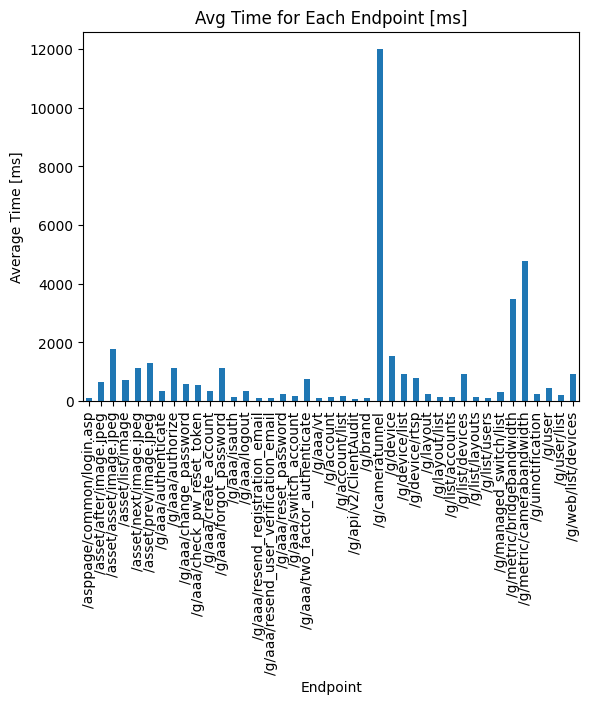

In [51]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Average Time [ms]')
plt.title('Avg Time for Each Endpoint [ms]')
plt.show()

## Breakdown: average response time by endpoint compared to avg time today

In [52]:
import pandas as pd
from datetime import datetime, timedelta
import pytz


avg_duration = df.groupby('Endpoint')['Duration till body received[ms]'].mean().reset_index()
avg_duration = avg_duration.rename(columns={'Duration till body received[ms]': 'avg_duration'})

# get the average duration for the last 24 hours
#last_24_hours = datetime.now() - timedelta(hours=24)
last_24_hours = datetime.now(tz=pytz.timezone('US/Central')) - timedelta(hours=24)
avg_duration_last_24_hours = df[df['Start Time CST'] >= last_24_hours].groupby('Endpoint')['Duration till body received[ms]'].mean().reset_index()
avg_duration_last_24_hours = avg_duration_last_24_hours.rename(columns={'Duration till body received[ms]': 'avg_duration 24_hrs'})

# merge the two dataframes on the 'endpoints' column
result = pd.merge(avg_duration, avg_duration_last_24_hours, on='Endpoint', how='left')

# calculate percentage change
result['percentage_change'] = ((result['avg_duration 24_hrs'] - result['avg_duration']) / result['avg_duration']) * 100

result = result.round(0) # round to whole numbers
# print the result
print(result.to_string(index=False))

                             Endpoint  avg_duration  avg_duration 24_hrs  percentage_change
            /asppage/common/login.asp         121.0                108.0              -11.0
              /asset/after/image.jpeg         659.0                259.0              -61.0
              /asset/asset/image.jpeg        1766.0               1070.0              -39.0
                    /asset/list/image         729.0                250.0              -66.0
               /asset/next/image.jpeg        1118.0                658.0              -41.0
               /asset/prev/image.jpeg        1310.0                284.0              -78.0
                  /g/aaa/authenticate         360.0                287.0              -20.0
                     /g/aaa/authorize        1132.0               1067.0               -6.0
               /g/aaa/change_password         587.0                567.0               -3.0
          /g/aaa/check_pw_reset_token         545.0                543.0        

In [53]:
# filter rows with percentage_change greater than 20%
result_filtered = result[result['percentage_change'] > 20].sort_values('percentage_change', ascending=False)

# print the filtered result without index
print(result_filtered.to_string(index=False))

                      Endpoint  avg_duration  avg_duration 24_hrs  percentage_change
         /g/api/v2/ClientAudit          86.0                350.0              306.0
                 /g/aaa/isauth         132.0                423.0              221.0
                /g/device/rtsp         805.0               1537.0               91.0
/g/aaa/two_factor_authenticate         769.0               1450.0               89.0
        /g/managed_switch/list         324.0                555.0               71.0
                /g/device/list         939.0               1416.0               51.0
           /g/web/list/devices         915.0               1329.0               45.0
                      /g/brand         111.0                157.0               41.0
               /g/list/devices         912.0               1246.0               37.0
     /g/metric/bridgebandwidth        3494.0               4211.0               21.0


### Worst performaning endpoint all time

In [54]:
df_sorted = df.sort_values(by='Duration till body received[ms]', ascending=False)
df_sorted.iloc[0]

Endpoint                                     /g/metric/camerabandwidth
Method                                                             GET
Status Code                                                        200
Start time                                  2023-04-29 17:45:24.544000
Duration till headers received[ms]                              203887
Duration till body received[ms]                                 203892
Request Body Length                                                  0
Response Body Length                                              8616
Test Result                                                       PASS
Start Time CST                        2023-04-29 12:45:24.544000-05:00
Name: 258550, dtype: object

### Worst performaning endpoint last 24 hours

In [55]:
df_last_24_hrs = df[df['Start Time CST'] >= last_24_hours]
#print (df[df_huh['Duration till body received[ms]'].idxmax()])
df_last_24_hrs = df_last_24_hrs.sort_values(by='Duration till body received[ms]', ascending=False)
max_duration_row = df_last_24_hrs.iloc[0]
print (max_duration_row)

Endpoint                                               /g/cameratunnel
Method                                                             GET
Status Code                                                        200
Start time                                  2023-04-30 21:14:48.969000
Duration till headers received[ms]                                 712
Duration till body received[ms]                                 102529
Request Body Length                                                  0
Response Body Length                                                52
Test Result                                                       PASS
Start Time CST                        2023-04-30 16:14:48.969000-05:00
Name: 226771, dtype: object


## Median response time at each hour - all endpoints

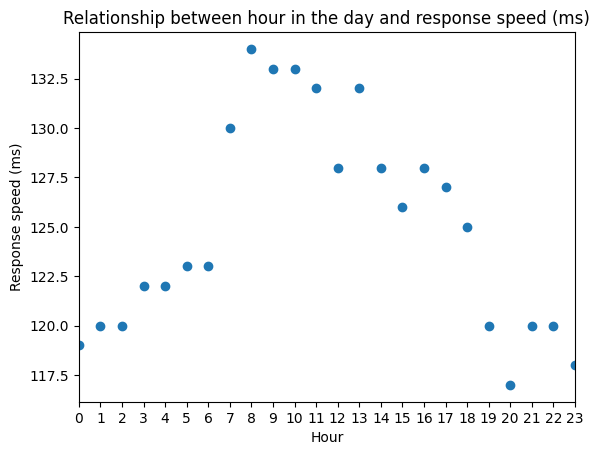

In [56]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour

#Calculate the mean duration for each hour
hourly_mean_duration = df.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()


## Median response time at each day for the last 20 days - all endpoints

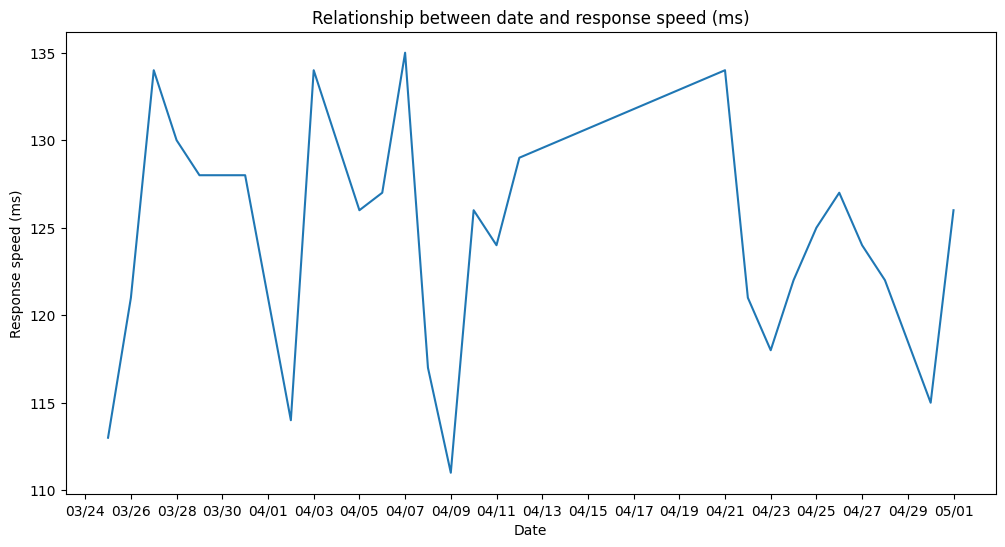

In [57]:
from matplotlib import dates as mpl_dates
import matplotlib.ticker as ticker


# Create a new column with the date value
df['Date'] = df['Start Time CST'].dt.date

# Calculate the mean duration for each day
daily_mean_duration = df.groupby('Date')['Duration till body received[ms]'].median()

# Create a new dataframe with last 20 days included
start_date = pd.Timestamp.now() - pd.Timedelta(days=20)
# Create a new dataframe with all dates included
#all_dates = pd.DataFrame({'Date': pd.date_range(start=df['Start Time CST'].min().date(), end=df['Start Time CST'].max().date())})
all_dates = pd.DataFrame({'Date': pd.date_range(start=start_date.date(), end=df['Start Time CST'].max().date())})

# Concatenate the daily mean duration data with the all-dates dataframe
result = pd.concat([all_dates.set_index('Date'), daily_mean_duration], axis=1, join='outer')

# Forward fill the missing values
result['Duration till body received[ms]'] = result['Duration till body received[ms]'].fillna(method='ffill')

# Build line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(result.index, result['Duration till body received[ms]'])
ax.set_xlabel('Date')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between date and response speed (ms)')

# Format the x-axis tick labels to display only the month and day
date_format = mpl_dates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))


plt.show()

## Speed throughout the day for endpoint - g/aaa/authenticate

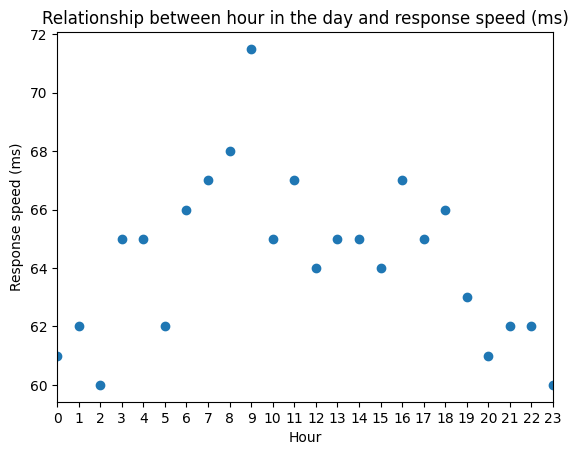

In [58]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour
df_auth = df[df['Endpoint'] == '/g/aaa/authenticate']

#Calculate the mean duration for each hour
hourly_mean_duration = df_auth.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()

In [59]:
import datetime
import pytz
from datetime import datetime
import calendar

today = datetime.today()
weekday_name = calendar.day_name[today.weekday()]

# filter the dataframe to include only the data for Tuesdays
df_every_someday = df[df['Start Time CST'].dt.weekday == today.weekday()]

# filter the dataframe to include only the data for today
now = datetime.now(tz=pytz.timezone('US/Central'))
df_today = df[df['Start Time CST'].dt.date == now.date()]

# calculate the mean duration for each group (Endpoint column)
mean_duration_every_someday = df_every_someday['Duration till body received[ms]'].mean()
mean_duration_today = df_today['Duration till body received[ms]'].mean()

percentage_change = ((mean_duration_today - mean_duration_every_someday) / mean_duration_every_someday) * 100

print (f"Today's mean duration: {mean_duration_today:.2f} ms, Other {weekday_name}s' mean duration: {mean_duration_every_someday:.2f} ms, Percentage change: {percentage_change:.2f}%")

Today's mean duration: 822.07 ms, Other Mondays' mean duration: 727.60 ms, Percentage change: 12.98%


# The response length by endpoint

In [60]:
grouped = df.groupby('Endpoint')['Response Body Length'].mean()

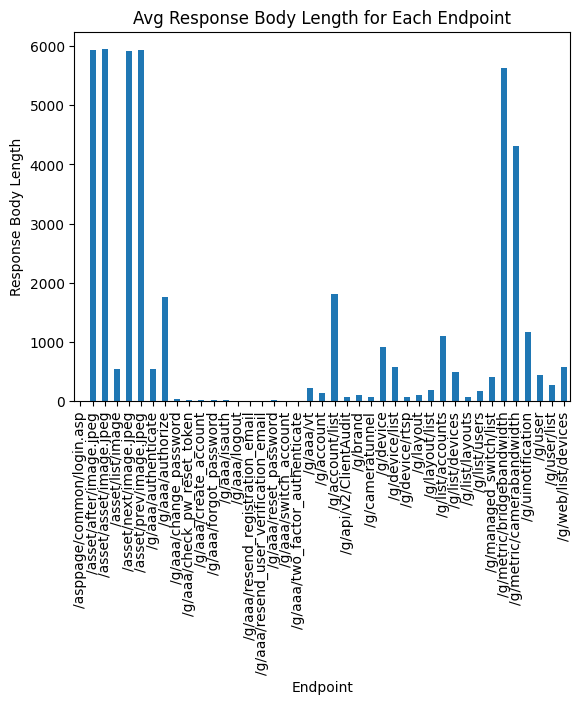

In [61]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Response Body Length')
plt.title('Avg Response Body Length for Each Endpoint')
plt.show()

In [22]:
import os
from zulip_integration import Zulip
zu = Zulip()
emoji = ":neutral:"
if percentage_change < -10.0:
    emoji = ":smile:"
elif percentage_change > 10.0:
    emoji = ":sad:"
zulip_msg =  f"Today's avg duration: {mean_duration_today:.2f} ms, Other {weekday_name}s' avg duration: {mean_duration_every_someday:.2f} ms \nPercentage change: {percentage_change:.2f}% "
zulip_msg += emoji
zu.send_msg(zulip_msg)
zulip_msg = "| Endpoint | Expected Duration | Today's Duration | % Change |\n"
zulip_msg += "| -------- | ----------------- | ---------------- | -------- |\n"
for index, row in result_filtered.iterrows():
    zulip_msg += f"| {row[0]} | {row[1]} ms | {row[2]} ms | {row[3]}% |\n"
zu.send_msg("WORST PERFORMING ENDPOINTS TODAY: \n")
zu.send_msg(zulip_msg)

{'result': 'success', 'msg': '', 'id': 6637579}
{'result': 'success', 'msg': '', 'id': 6637580}
{'result': 'success', 'msg': '', 'id': 6637581}
